In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


In [2]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.losses import MeanAbsolutePercentageError

#from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [4]:
DIR_DATA  = '../input/diploma/'

In [5]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

# Вспомогательные функции расчета метрик.

In [6]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [8]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [9]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Анализ целевой переменной.

# Вспомогательная функция извлечения числа из записи доллара.

In [10]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return np.NaN
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return float(dollar_res)


In [11]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [12]:
data_d['target'].isna().unique()

array([False,  True])

In [13]:
data_d.loc[data_d['target'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
61,NaN,NaN,Single Family,7353 Boysenberry Ct,2.0,"{'atAGlanceFacts': [{'factValue': '1983', 'fac...",Yes,Jacksonville,"[{'rating': ['7/10', '2/10', '4/10'], 'data': ...","1,446 sqft",32244,3,FL,1,NaN,NaN,NaN,NaN
94,Pre-foreclosure / auction,NaN,Townhouse,20663 Fm 2154 Rd,Bathrooms: 4,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",Yes,College Station,"[{'rating': ['NA', '2/10', 'NA'], 'data': {'Di...","Total interior livable area: 4,179 sqft",77845,4 bd,TX,2.0,NaN,NaN,NaN,NaN
121,/ auction,NaN,Single Family,3719 Suffolk St,2,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",Yes,Durham,"[{'rating': ['2/10', '5/10', '4/10'], 'data': ...","2,327",27707,3,NC,0.0,NaN,NaN,NaN,NaN
169,NaN,NaN,Single Family,8201 Waterford Ave,2.0,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",NaN,Tamarac,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...","1,280 sqft",33321,2,FL,1.0,NaN,NaN,NaN,NaN
174,Pre-foreclosure / auction,NaN,Single Family,17508 Puritas Ave,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",NaN,Cleveland,"[{'rating': ['2/10', '2/10'], 'data': {'Distan...","Total interior livable area: 1,209 sqft",44135,2 bd,OH,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376495,recently sold,NaN,single-family home,7433 Creekland Dr,2 Baths,"{'atAGlanceFacts': [{'factValue': '2003', 'fac...",NaN,Reno,"[{'rating': ['None/10', '5/10', '3/10'], 'data...","1,082 sqft",89506,2 Beds,NV,1,NaN,NaN,NaN,NaN
376528,foreclosure,NaN,apartment,5652 S Justine St,2 Baths,"{'atAGlanceFacts': [{'factValue': '2009', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '1/10', '2/10'], 'data': ...","2,351 sqft",60636,6 Beds,IL,NaN,NaN,NaN,NaN,NaN
376577,Foreclosed,NaN,Single Family,1851 W Landstreet Rd # 3233,NaN,"{'atAGlanceFacts': [{'factValue': '1973', 'fac...",NaN,Orlando,"[{'rating': ['4/10', '2/10', '5/10'], 'data': ...",Total interior livable area: 620 sqft,32809,-- bd,FL,NaN,NaN,NaN,NaN,NaN
376937,NaN,NaN,NaN,8501 NW 53rd Ter,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Doral,"[{'rating': ['10/10', '8/10'], 'data': {'Dista...",NaN,33166,1.74 acres,FL,NaN,NaN,NaN,NaN,NaN


In [14]:
data_d.dropna(axis=0,subset=['target'],inplace=True)

In [15]:
data_d['target'].isna().unique()

array([False])

<AxesSubplot:xlabel='target', ylabel='Density'>

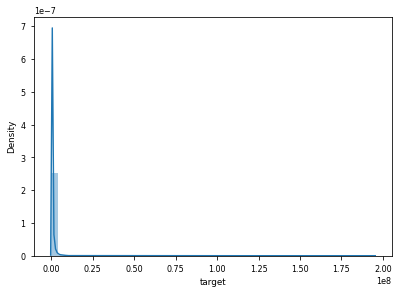

In [16]:
sns.distplot(data_d['target'])

# Удаление выбросов в целевой переменной.

In [17]:
data_d.loc[data_d['target'].median()]

status                                                     Active
private pool                                                  NaN
propertyType                        Condo/Townhome/Row Home/Co-Op
street                              1080 Wisconsin Ave NW Apt 304
baths                                                         1.5
homeFacts       {'atAGlanceFacts': [{'factValue': '1981', 'fac...
fireplace                                                     NaN
city                                                   Washington
schools         [{'rating': ['8', '8', '8', '8', '9', '9', 'NR...
sqft                                                          946
zipcode                                                     20007
beds                                                            1
state                                                          DC
stories                                                        3+
mls-id                                                        NaN
PrivatePoo

In [18]:
data_d['target'].mean()

644757.5030263888

In [19]:
data_d.loc[data_d['target']>data_d['target'].mean()]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,2395000.0
10,for sale,NaN,coop,14205 Roosevelt Ave #512,2 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...","1,300 sqft",11354,3 Beds,NY,NaN,NaN,NaN,3087630,669000.0
15,New,NaN,2 Story,930 52nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0
17,Active,NaN,Townhouse,24 W 126th St,NaN,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,New York,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...","3,325",10027,NaN,NY,NaN,NaN,NaN,4975368,2650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377168,for sale,NaN,single-family home,24080 Tuscany Ct,5 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Bonita Springs,"[{'rating': ['3/10', '8/10', '4/10', '5/10', '...","5,992 sqft",34134,4 Beds,FL,NaN,NaN,yes,219077435,2495000.0
377174,for sale,NaN,single-family home,1107 E Euclid Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,San Antonio,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950 sqft,78212,2 Beds,TX,1.0,NaN,yes,1391618,799500.0
377179,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,1249000.0


In [20]:
data_d.loc[data_d['target']>500000]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,2895000.0
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,2395000.0
10,for sale,NaN,coop,14205 Roosevelt Ave #512,2 Baths,"{'atAGlanceFacts': [{'factValue': '1965', 'fac...",NaN,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...","1,300 sqft",11354,3 Beds,NY,NaN,NaN,NaN,3087630,669000.0
12,for sale,NaN,single-family home,16373 NW 16th St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",NaN,Pembroke Pines,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...","2,839 sqft",33028,4 Beds,FL,1.0,NaN,yes,A10767242,525000.0
15,New,NaN,2 Story,930 52nd St,NaN,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",NaN,11219,NaN,NY,NaN,NaN,NaN,3182740,1650000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377174,for sale,NaN,single-family home,1107 E Euclid Ave,NaN,"{'atAGlanceFacts': [{'factValue': '1938', 'fac...",NaN,San Antonio,"[{'rating': ['4/10', '5/10', '3/10'], 'data': ...",950 sqft,78212,2 Beds,TX,1.0,NaN,yes,1391618,799500.0
377179,For sale,NaN,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","1,417",20001,2,DC,3.0,NaN,NaN,DCDC444306,799000.0
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,1249000.0
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,674999.0


In [21]:
data_d = data_d[(data_d['target'] < 550000)]

<AxesSubplot:xlabel='target', ylabel='Density'>

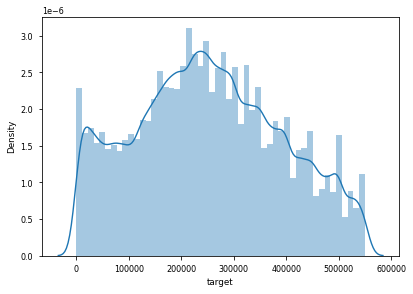

In [22]:
sns.distplot(data_d['target'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f9380f9eb50>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f9380f906d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f9380f9eb90>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f9380f9e990>}

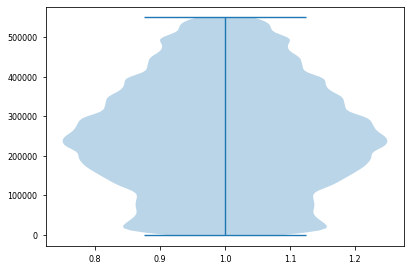

In [23]:
plt.violinplot(data_d['target'])

In [24]:
data_d['target'].isna().unique()

array([False])

In [25]:
data_d.loc[data_d['target']==0]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target


In [26]:
data_d.loc[data_d['target'].min()]

status                                                   for sale
private pool                                                  NaN
propertyType                                   single-family home
street                                          12911 E Heroy Ave
baths                                                     3 Baths
homeFacts       {'atAGlanceFacts': [{'factValue': '2019', 'fac...
fireplace                                                     NaN
city                                               Spokane Valley
schools         [{'rating': ['4/10', 'None/10', '4/10'], 'data...
sqft                                                   1,947 sqft
zipcode                                                     99216
beds                                                       3 Beds
state                                                          WA
stories                                                       2.0
mls-id                                                        NaN
PrivatePoo

In [27]:
#data_d.target = np.log(data_d.target[data_d.target > 0])

In [28]:
#data_d['target'].isna().unique()

# Обработка признака homeFacts.

In [29]:
def facts_extraction(slovar):
    if slovar.find('atAGlanceFacts')>-1:
        slovar1 = eval(slovar)
       # print(type(slovar1))
        #print(slovar1)
        slovar2=slovar1.get('atAGlanceFacts')
       # print(type(slovar2))
       # print(slovar2)
        
        lst = ['']
        for i in slovar2:
            
            lst.append(i.get('factValue'))
        lst_res=lst[1:]
        return lst_res
            
    else: return np.NaN


In [30]:
data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))
t = data_d['homeFacts']
t_lst = t.tolist()
columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']
t1 = pd.DataFrame(t_lst, columns = columns)
data_d = data_d.join(t1)

In [31]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           192550 non-null  object 
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            244803 non-null  object 
 10  zipcode         274467 non-null  object 
 11  beds            204895 non-null  object 
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

# Разбор признака школы.

In [32]:
data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))
t = data_d['schools']
t_lst = t.tolist()
t5_lst = []
for i in t_lst:
    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
    t5_lst.append(i1)

df_lst = pd.DataFrame(t5_lst,dtype=str)
data_d = data_d.join(df_lst)

In [33]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           192550 non-null  object 
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            244803 non-null  object 
 10  zipcode         274467 non-null  object 
 11  beds            204895 non-null  object 
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

# Площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, возвращает NaN.

In [34]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return np.NaN
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [35]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

Вместо нулевых значений подставляю нан для упрощения последующей замены.

In [36]:
data_d.sqft = data_d.sqft.apply(lambda x: np.NaN if x==0.0 else x)

In [37]:
data_d.loc[data_d['sqft'].isna() == True]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"[, , , , , 10,019 sqft, None]",NaN,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se..."
7,Active,NaN,NaN,6094 Mingle Dr,NaN,"[1976, , , , , 8,750 Sq. Ft., $57 / Sq. Ft.]",NaN,Memphis,"{'rating': ['4', '2', '2'], 'data': {'Distance...",NaN,38115,NaN,TN,NaN,NaN,NaN,10063506,68000.0,2019,None,Gas,Central,Attached Garage,"2,056 sqft",$162,"['4/10', '3/10', '2/10']","['0.7 mi', '0.6 mi', '1.9 mi']","['PK-5', '5-8', '9-12']","['Edgewood Elementary School', 'Landrum Middle..."
40,Active,NaN,NaN,1104 Rotonda Cir,NaN,"[, , , , , —, None]",NaN,ROTONDA WEST,"{'rating': ['6', '6', '7'], 'data': {'Distance...",NaN,33947,NaN,FL,NaN,NaN,NaN,D6107075,54000.0,1974,,Electric,,,1.7 acres,$344/sqft,"['8/10', '6/10', '8/10']","['0.93mi', '0.59mi', '0.41mi']","['9-12', '6-8', 'PK-5']","['Dunwoody High School', 'Peachtree Middle Sch..."
48,Active,NaN,NaN,18b Sitton-Mills Pl,NaN,"[, , , , , —, None]",NaN,Signal Mountain,"{'rating': ['8', 'NR', '7', '4'], 'data': {'Di...",NaN,37377,NaN,TN,NaN,NaN,NaN,1310212,125000.0,1918,,Baseboard,,Off Street,"7,680 sqft",$617/sqft,"['6/10', '3/10', '4/10']","['0.33mi', '0.7mi', '0.18mi']","['6-8', 'PK-5', '9-12']","['Denny Middle School', 'Roxhill Elementary Sc..."
49,Active,NaN,Land,23443 N 65th Ave,NaN,"[, , , , , 50530, None]",NaN,Glendale,"{'rating': ['8', '9', '7', '8', '9', '7', 'NR'...",NaN,85310,NaN,AZ,NaN,NaN,NaN,5876037,275000.0,1960,1993,"Central, Electric",Central Air,,"10,200 Sq. Ft.",$190 / Sq. Ft.,"['4', '7', '7']","['1.4 mi', '2.6 mi', '4.8 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Peace River Elementary School', 'Port Charlo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377141,Active,NaN,NaN,Mantova Ct,NaN,"[, , , , , —, None]",NaN,ORLANDO,"{'rating': ['7', '6', 'NR', 'NR', '7'], 'data'...",NaN,32836,NaN,FL,NaN,NaN,NaN,O5763033,400000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377146,for sale,NaN,single-family home,206/208 N Randolph St,NaN,"[1910, , , , , 5488 sqft, None]",NaN,Indianapolis,"{'rating': ['1/10'], 'data': {'Distance': ['0....",NaN,46201,NaN,IN,NaN,NaN,NaN,21686741,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377154,Active,NaN,NaN,2104 Russell Ave,NaN,"[, , , , , 6,970 Sq. Ft., None]",NaN,Charlotte,"{'rating': ['2', '3', '3'], 'data': {'Distance...",NaN,28216,NaN,NC,NaN,NaN,NaN,3571015,99990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377161,Active,NaN,Land,Homestead Dr Lot 1,NaN,"[, , , , , 1, None]",NaN,Columbiana,"{'rating': ['8', '9', '8', 'NR'], 'data': {'Di...",NaN,44408,NaN,OH,NaN,NaN,NaN,3382834,45000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data_d[['sqft']] = data_d[['sqft']].fillna(data_d['sqft'].median())

In [39]:
data_d['sqft'].isna().sum()

0

In [40]:
data_d.loc[data_d['sqft'].min()]

status                                                     for sale
private pool                                                    NaN
propertyType                                     single-family home
street                                            12911 E Heroy Ave
baths                                                       3 Baths
homeFacts                      [2019, , , , , 5828 sqft, $159/sqft]
fireplace                                                       NaN
city                                                 Spokane Valley
schools           {'rating': ['4/10', 'None/10', '4/10'], 'data'...
sqft                                                         1947.0
zipcode                                                       99216
beds                                                         3 Beds
state                                                            WA
stories                                                         2.0
mls-id                                          

<AxesSubplot:xlabel='sqft', ylabel='Density'>

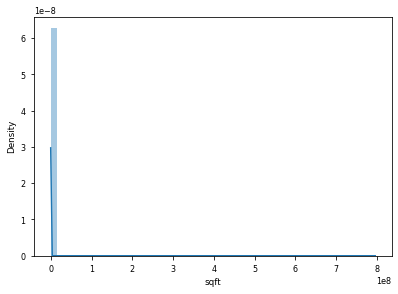

In [41]:
sns.distplot(data_d['sqft'])

In [42]:
data_d.loc[data_d['sqft'].median()]

status                                                     for sale
private pool                                                    NaN
propertyType                                                  condo
street                                        2924 Collins Ave #503
baths                                                       2 Baths
homeFacts            [1980, 1980, Electric, Central, , , $487/sqft]
fireplace                                                       NaN
city                                                    Miami Beach
schools           {'rating': ['5/10', '10/10', '4/10', '10/10', ...
sqft                                                         1077.0
zipcode                                                       33140
beds                                                         2 Beds
state                                                            FL
stories                                                         NaN
mls-id                                          

In [43]:
data_d['sqft_big'] = data_d['sqft'].apply(lambda x: 1 if x > 2300 else 0)

In [44]:
data_d.sqft = data_d.sqft.apply(lambda x: 2301 if x>2300 else x)

# Визуализация признака площадь

<AxesSubplot:xlabel='sqft', ylabel='Density'>

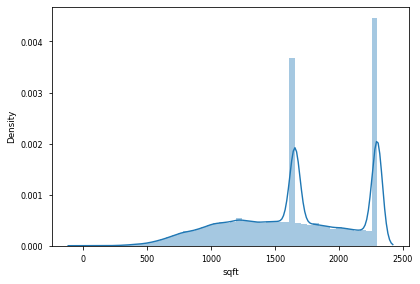

In [45]:
sns.distplot(data_d['sqft'])


Text(0.5, 1.0, 'Зависимость цены от площади')

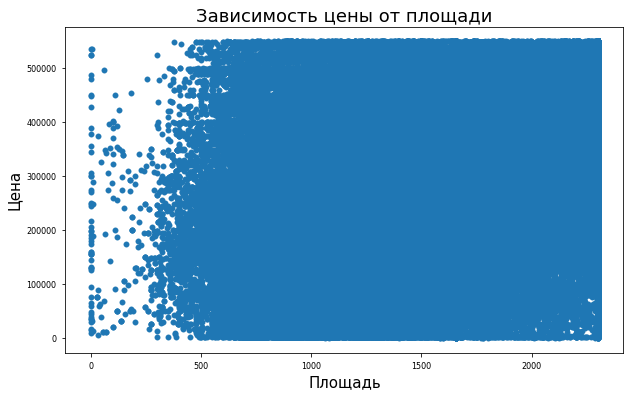

In [46]:
x = data_d['sqft']
y = data_d['target']
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

<AxesSubplot:xlabel='sqft'>

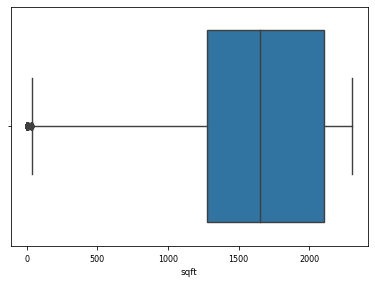

In [47]:
sns.boxplot(data_d['sqft'])

# Спальни - приведение к численному виду.

In [48]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big
364340,A Active,NaN,Land,4500 Harris Hill Rd,NaN,"[1922, , , , , 1079000, None]",NaN,Falconer,"{'rating': ['5', '5', 'NR', 'NR', 'NR'], 'data...",1596.0,14733,# Bedrooms 1st Floor,NY,NaN,NaN,NaN,R1171774,79000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [49]:
#data_d = data_d.drop(data_d['beds'] == '# Bedrooms 1st Floor')

Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [50]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [51]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [52]:
#data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor'))
data_d.beds = data_d.beds.apply(lambda x: 1 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if x == '1-2 Beds' or x == '-- bd' else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('sqft')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('acres')>-1) else x)
data_d.beds = data_d.beds.apply(lambda x: 1 if (str(x).find('# Bedrooms 1st Floor')>-1) else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

1                                                                         156446
3 Beds                                                                     42508
4 Beds                                                                     24565
2 Beds                                                                     20274
3 bd                                                                       10939
4 bd                                                                        6034
5 Beds                                                                      4770
2 bd                                                                        4573
5 bd                                                                        1303
6 Beds                                                                      1123
1 bd                                                                         969
6 bd                                                                         253
7 Beds                      

In [53]:
data_d.loc[data_d['beds'] == '# Bedrooms 1st Floor']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big


Вспомогательная функция для выбора числового значения признака спальни.

In [54]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [55]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [56]:
data_d['beds'].unique()                        


array([ 1,  3,  2,  4,  5,  8,  6,  7, 10, 64, 24,  9, 11, 16, 18, 12, 44,
       17, 14, 13, 15, 28, 20])

In [57]:
data_d['beds'].isna().sum()

0

In [58]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           192550 non-null  object 
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            274467 non-null  float64
 10  zipcode         274467 non-null  object 
 11  beds            274467 non-null  int64  
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

# Визуализация и обработка признака спальни (beds).

In [59]:
data_d['beds_big']= data_d['beds'].apply(lambda x: 1 if x>7 else 0)

In [60]:
data_d.beds = data_d.beds.apply(lambda x: 11 if x>10 else x)

In [61]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           192550 non-null  object 
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            274467 non-null  float64
 10  zipcode         274467 non-null  object 
 11  beds            274467 non-null  int64  
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

In [62]:
data_d['beds'].isna().sum()

0

<AxesSubplot:xlabel='beds', ylabel='Density'>

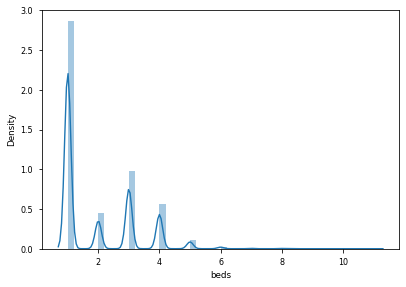

In [63]:
sns.distplot(data_d['beds'])

In [64]:
y = data_d['target']

In [65]:
x = data_d['beds']

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

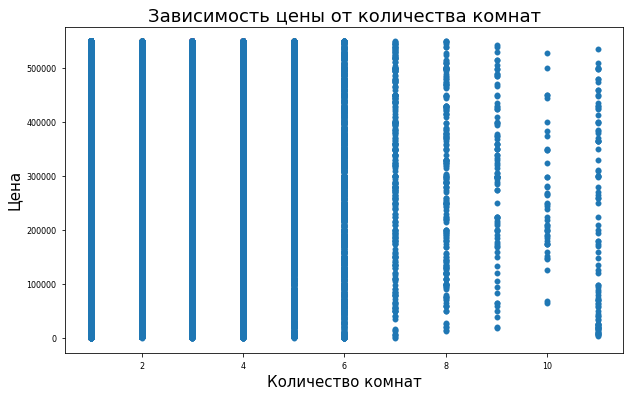

In [66]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)


<AxesSubplot:xlabel='beds'>

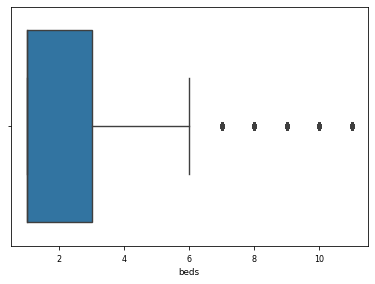

In [67]:
sns.boxplot(data_d['beds'])

# Ванны - приведение к численному виду.

Вспомогательная функция извлекает численное значение из текста. Если значение некорректно, выдает 1. Применила здесь, а также для обработки этажей.)

In [68]:
def extract_num_recurr(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 1
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num(stroka,len_s,i+1)

def main_extract_num(stroka):   
    len_s=len(stroka)-1
    
    return extract_num(stroka,len_s,0)

In [69]:
data_d.baths = data_d.baths.apply(lambda x: round(main_extract_num(str(x)),1))

In [70]:
data_d['baths'].unique()   

array([3.50e+00, 3.00e+00, 1.00e+00, 2.00e+00, 4.00e+00, 2.10e+00,
       2.50e+00, 4.50e+00, 5.50e+00, 1.50e+00, 0.00e+00, 7.50e+02,
       5.00e+00, 6.00e+00, 7.00e+00, 8.00e+00, 1.90e+01, 1.80e+00,
       1.30e+01, 1.10e+00, 1.20e+01, 2.41e+02, 6.50e+00, 1.40e+01,
       2.20e+01, 2.20e+00, 1.80e+01, 1.00e+01, 2.80e+00, 1.60e+01,
       1.10e+01, 1.50e+01, 3.80e+00, 3.20e+00, 9.00e+00, 1.20e+00,
       2.00e+01, 2.50e+01, 5.00e-01, 8.50e+00, 3.10e+00, 3.00e+01,
       8.00e-01, 1.70e+01, 4.10e+00, 2.80e+01])

In [71]:
data_d['baths'].isna().sum()

0

In [72]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274467 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          245007 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250827 non-null  object 
 3   street          274466 non-null  object 
 4   baths           274467 non-null  float64
 5   homeFacts       274467 non-null  object 
 6   fireplace       66993 non-null   object 
 7   city            274447 non-null  object 
 8   schools         274467 non-null  object 
 9   sqft            274467 non-null  float64
 10  zipcode         274467 non-null  object 
 11  beds            274467 non-null  int64  
 12  state           274467 non-null  object 
 13  stories         167742 non-null  object 
 14  mls-id          19144 non-null   object 
 15  PrivatePool     22559 non-null   object 
 16  MlsId           224520 non-null  object 
 17  target    

# Визуализация и обработка признака ванны (baths).

<AxesSubplot:xlabel='baths', ylabel='Density'>

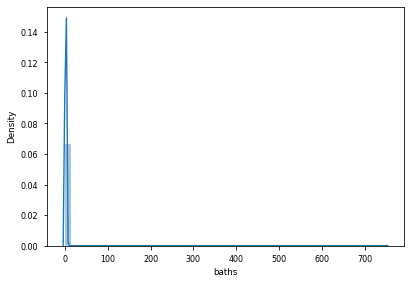

In [73]:
sns.distplot(data_d['baths'])

In [74]:
data_d.loc[data_d['baths']>10]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big
1109,Active,NaN,"Attached or 1/2 Duplex, Traditional",3624 Douglas Ave,750.0,"[1993, 1993, , Central A/C (Electric), Central...",1,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",1758.0,75219,1,TX,NaN,NaN,NaN,14240509,499000.0,None,None,None,None,None,None,None,"['NA', '9/10', '8/10']","['2.2 mi', '3.8 mi', '5.1 mi']","['PK-5', '6-8', '9-12']","['Ellison Elementary School', 'Garcia Middle S...",0,0
3594,Active,NaN,NaN,601 W 11th Ave #409,750.0,"[1981, , Forced Air, Natural Gas, Central Air,...",NaN,DENVER,"{'rating': ['5', 'NR', '5', '2'], 'data': {'Di...",873.0,80204,1,CO,NaN,NaN,NaN,7106586,348900.0,2006,2006,Forced Air,Central,Attached Garage,"4,420 sqft",$165/sqft,"['3/10', '8/10', '4/10', '5/10', '6/10', '5/10...","['13.73mi', '10.69mi', '17.81mi', '13.02mi', '...","['9-12', 'PK-5', 'PK-5', '6-8', '6-8', 'PK-5',...","['South Fort Myers High School', 'Rayma C. Pag...",0,0
6031,for sale,NaN,single-family home,3206 Briscoe Trl,19.0,"[2007, , Forced Air, Central, Attached Garage,...",yes,San Antonio,"{'rating': ['7/10', '7/10'], 'data': {'Distanc...",2301.0,78253,5,TX,2.0,NaN,yes,1429315,369000.0,1976,1977,Forced Air,Central,,,$155/sqft,"['6/10', '3/10', '6/10']","['0.93mi', '0.13mi', '1.71mi']","['6-8', 'PK-8', '9-12']","['Coral Springs Middle School', 'Coral Springs...",1,0
6467,for sale,NaN,single-family home,15044 120th Ave,13.0,"[2008, , , , , 2,247 sqft, $452/sqft]",NaN,Jamaica,"{'rating': ['5/10', '3/10'], 'data': {'Distanc...",1162.0,11434,3,NY,2,NaN,NaN,9JLBZQ,525000.0,1950,,Forced Air,Central,Off Street,"7,170 sqft",$109/sqft,"['4/10', '4/10', '2/10', '6/10', 'None/10', '3...","['0.92mi', '0.82mi', '0.3mi', '1.17mi', '0.73m...","['5', '9-12', 'PK-4', '7-8', '9-12', '6']","['Dan Powell Intermediate School', 'Everman Hi...",0,0
7693,Active,NaN,Condo/Townhome,3314 Douglas Ave Unit 202D,750.0,"[1984, , , Central A/C (Gas), Central Heat (Ga...",3,Dallas,"{'rating': ['4', '3', '2', '10'], 'data': {'Di...",1336.0,75219,1,TX,3,NaN,NaN,14237911,285000.0,2017,,,,,"7,492 sqft",$190/sqft,"['3/10', '3/10', '5/10']","['4.23mi', '1.21mi', '0.95mi']","['9-12', '6-8', 'PK-5']","['Prairie View High School', 'Otho E Stuart Mi...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366559,Active,NaN,NaN,1374 N Yates St,750.0,"[2019, , Forced Air, Natural Gas, Central Air,...",NaN,DENVER,"{'rating': ['2', '2', '2'], 'data': {'Distance...",1181.0,80204,1,CO,NaN,NaN,NaN,1592091,449900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
372603,Active,NaN,NaN,601 Pennsylvania Ave NW #212,750.0,"[1991, , , , , —, $561 / Sq. Ft.]",NaN,Washington,"{'rating': ['8', '8', '3', '5'], 'data': {'Dis...",801.0,20004,1,DC,NaN,NaN,NaN,DCDC444552,449000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
375634,Active,NaN,"Condo/Townhome, Contemporary/Modern",3225 Turtle Creek Blvd #1646,750.0,"[1998, 1998, , Central A/C (Electric), Central...",NaN,Dallas,"{'rating': ['5', '5', '2', '10'], 'data': {'Di...",832.0,75219,1,TX,NaN,NaN,NaN,14215205,219500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376012,Active,NaN,"Condo/Townhome, Other (See Remarks)",2262 Alterbrook Ln,750.0,"[2019, , , Central A/C (Electric), Central Hea...",NaN,Dallas,"{'rating': ['4', '3', '2', '10'], 'data': {'Di...",2102.0,75219,1,TX,NaN,NaN,NaN,14204976,464900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [75]:
data_d = data_d[data_d['baths']<10]

<AxesSubplot:xlabel='baths', ylabel='Density'>

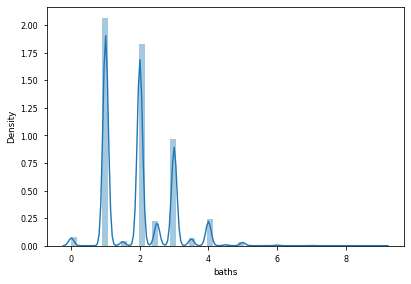

In [76]:
sns.distplot(data_d['baths'])

In [77]:
x = data_d['baths']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от оборудования ванн')

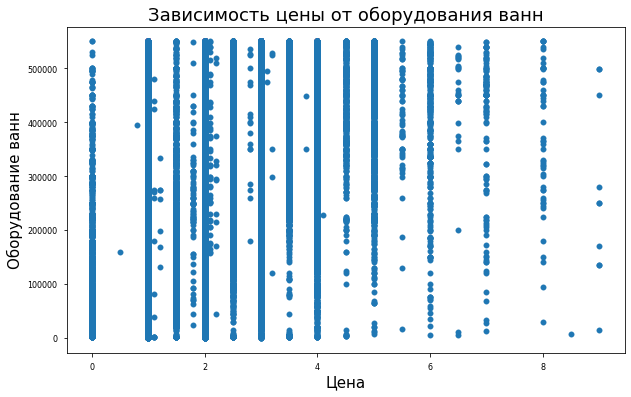

In [78]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Оборудование ванн', fontsize = 15)
plt.title('Зависимость цены от оборудования ванн', fontsize = 18)

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [79]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [80]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [81]:
data_d['fireplace'].unique()

array([0, 1, 2])

In [82]:
data_d['fireplace'].isna().sum() 

0

In [83]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274282 entries, 0 to 377184
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          244823 non-null  object 
 1   private pool    2712 non-null    object 
 2   propertyType    250666 non-null  object 
 3   street          274281 non-null  object 
 4   baths           274282 non-null  float64
 5   homeFacts       274282 non-null  object 
 6   fireplace       274282 non-null  int64  
 7   city            274262 non-null  object 
 8   schools         274282 non-null  object 
 9   sqft            274282 non-null  float64
 10  zipcode         274282 non-null  object 
 11  beds            274282 non-null  int64  
 12  state           274282 non-null  object 
 13  stories         167675 non-null  object 
 14  mls-id          19140 non-null   object 
 15  PrivatePool     22557 non-null   object 
 16  MlsId           224341 non-null  object 
 17  target    

In [84]:
x = data_d['fireplace']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

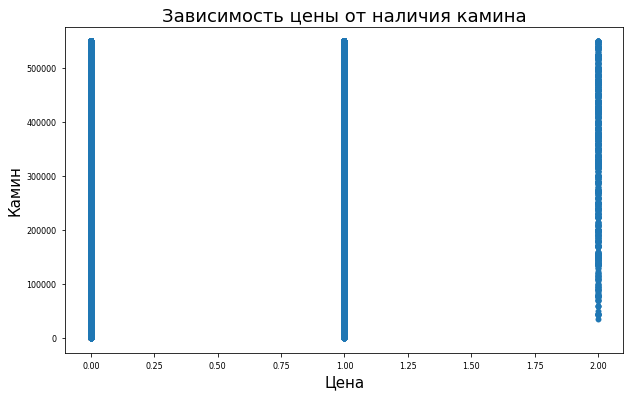

In [85]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Камин', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

# Бассейн. Анализ.

In [86]:
data_d['private pool'].value_counts()

Yes    2712
Name: private pool, dtype: int64

In [87]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big
205,For sale,Yes,Single Family,1403 Betton Rd,2.0,"[1958, 1980, Heat pump, Central, 1 space, 0.45...",1,Tallahassee,"{'rating': ['4/10', '5/10', '7/10'], 'data': {...",2301.0,32308,3,FL,NaN,302221,NaN,NaN,385000.0,1973,1973,Central Electric,Central Gas,,"7,480 Sq. Ft.",$110 / Sq. Ft.,"['8', '7', '7']","['1.9 mi', '1.7 mi', '1.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Ray Daily Elementary School', 'West Briar Mi...",1,0
321,For sale,Yes,Single Family,3296 Ledgewood Cir,3.0,"[2017, , Forced air, Central, 2 spaces, 3,484 ...",0,Riverside,"{'rating': ['4/10', '4/10', '6/10'], 'data': {...",2135.0,92503,3,CA,2.0,IV19242188,NaN,NaN,525000.0,1955,,,,,"8,190 Sq. Ft.",$81 / Sq. Ft.,"['2', '3', '3']","['0.5 mi', '1.1 mi', '0.3 mi']","['K to 5', '6 to 8', '9 to 12']","['Willow Oaks Elementary School', 'Colonial Mi...",0,0
355,For sale,Yes,Mobile / Manufactured,2250 N Broadway # 42,2.0,"[1976, , Forced air, Central, 2 spaces, -- sqf...",0,Escondido,"{'rating': ['4/10', '4/10', '6/10'], 'data': {...",1536.0,92026,2,CA,0.0,190034991,NaN,NaN,119000.0,,,Forced Air,Central,Attached Garage,5.00 acres,$142/sqft,"['8/10', '9/10', '5/10']","['5.01mi', '5.07mi', '0.23mi']","['6-8', '9-12', 'PK-5']","['Rossview Middle School', 'Rossview High Scho...",0,0
425,Pre-foreclosure / auction,Yes,Single Family,7632 Hillside Dr,2.0,"[1964, 1964, Forced air, Central, , 8,624 sqft, ]",1,Jacksonville,"{'rating': ['5/10', '2/10', '4/10'], 'data': {...",1245.0,32221,3,FL,1.0,NaN,NaN,NaN,128103.0,1959,,Other,Central,Carport,0.27 acres,$104/sqft,"['3/10', '5/10']","['3.64mi', '3.64mi']","['1-5', '6-8']","['Bramlette Elementary School', 'Judson Middle...",0,0
447,For sale,Yes,Single Family,5370 Christie Ann Pl # 17,2.0,"[1992, 1992, Forced air, Central, Attached Gar...",0,Sarasota,"{'rating': ['10/10', '9/10', '6/10'], 'data': ...",1936.0,34233,3,FL,1.0,O5821850,NaN,NaN,258000.0,1986,,Electric Heat,Central Heating,,"3,024 Sq. Ft.",$118 / Sq. Ft.,"['8', '10', '8']","['1.2 mi', '2.8 mi', '1.3 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Stone Oak Elementary School', 'Bush Middle S...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376298,Pre-foreclosure,Yes,Single Family,15369 Daybreak Ln,3.0,"[1990, 2007, Other, Central, 3 spaces, 6,011 s...",1,Fontana,"{'rating': ['4/10', '3/10', '4/10'], 'data': {...",2225.0,92337,5,CA,2.0,NaN,NaN,NaN,399094.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376340,For sale,Yes,Condo,200 River Vista Dr UNIT 436,2.0,"[2010, , Forced air, Central, Attached Garage,...",0,Atlanta,"{'rating': ['9/10', '6/10', '6/10'], 'data': {...",1299.0,30339,2,GA,1.0,8690633,NaN,NaN,295000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376582,For sale,Yes,Single Family,3235 Landover Blvd,2.0,"[2005, 2005, Other, Central, 1 space, 10,741 s...",0,Spring Hill,"{'rating': ['4/10', '6/10'], 'data': {'Distanc...",2256.0,34609,4,FL,1.0,2204520,NaN,NaN,225000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
376686,For sale,Yes,Single Family,2609 S Marigold Ave,3.0,"[1979, 1979, Forced air, Central, 2 spaces, 7,...",0,Ontario,"{'rating': ['7/10', '6/10', '5/10'], 'data': {...",1726.0,91761,3,CA,2.0,IV19252050,NaN,NaN,479000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [88]:
data_d['propertyType'].value_counts(normalize=True)

single-family home                                             0.272630
Single Family                                                  0.180140
Single Family Home                                             0.098087
lot/land                                                       0.070871
condo                                                          0.066419
                                                                 ...   
Penthouse, Low Rise                                            0.000004
Traditional, Loft with Bedrooms                                0.000004
Condo/Townhome, French, Split Level                            0.000004
Traditional, Colonial, Federal                                 0.000004
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000004
Name: propertyType, Length: 884, dtype: float64

In [89]:
data_d.propertyType = data_d.propertyType.apply(lambda x: str(x))

In [90]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [91]:
data_d.propertyType = data_d.propertyType.apply(lambda x: x.lower())

In [92]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'mlf' if (x.find('multi')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'ctmp' if (x.find('contempor')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'loft' if (x.find('loft')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'twnh' if (x.find('townhouse')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'condo' if (x.find('condo')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sn_dtch' if (x.find('single detached')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'eng' if (x.find('english')>-1) else x)
data_d.propertyType = data_d.propertyType.apply(lambda x: 'other' if x not in ['mlf','ctmp','loft','twnh','condo','sn_dtch','eng'] else x)

In [93]:
data_d['propertyType'].value_counts()

other      214443
condo       34421
twnh        14316
mlf          5946
ctmp         2836
sn_dtch      2261
loft           32
eng            27
Name: propertyType, dtype: int64

Преобразование к численному виду.

In [94]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes
data_d['propertyType_cat'] = data_d['propertyType_cat'].astype('category')

In [95]:
data_d['propertyType_cat'].isna().sum() 

0

In [96]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274282 entries, 0 to 377184
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            244823 non-null  object  
 1   private pool      2712 non-null    object  
 2   propertyType      274282 non-null  category
 3   street            274281 non-null  object  
 4   baths             274282 non-null  float64 
 5   homeFacts         274282 non-null  object  
 6   fireplace         274282 non-null  int64   
 7   city              274262 non-null  object  
 8   schools           274282 non-null  object  
 9   sqft              274282 non-null  float64 
 10  zipcode           274282 non-null  object  
 11  beds              274282 non-null  int64   
 12  state             274282 non-null  object  
 13  stories           167675 non-null  object  
 14  mls-id            19140 non-null   object  
 15  PrivatePool       22557 non-null   object  
 16  Ml

In [97]:
x = data_d['propertyType_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от типа собственности')

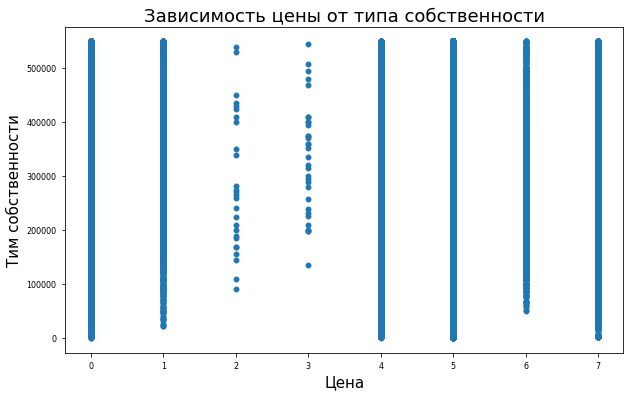

In [98]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Тим собственности', fontsize = 15)
plt.title('Зависимость цены от типа собственности', fontsize = 18)

# Город

In [99]:
data_d.city.fillna('others',inplace=True)

In [100]:
data_d['city'].isna().sum()

0

In [101]:
t = data_d['city'].value_counts()

In [102]:
t_df = pd.DataFrame(t)

In [103]:
t_df.loc[t_df['city']==np.NaN]

,city


In [104]:
t_df['city'].isna().sum()

0

In [105]:
dict_t = t_df.to_dict()

In [106]:
dict_city = dict_t.get('city')

In [107]:
data_d['city'].isna().sum()

0

Вспомогательная функция присваивает значение others, если число вхождений данного города невелико. (Здесь меньше 500.)

In [108]:
def other_cities(x1,d):
    if x1==np.NaN:
        return ('others')
    elif d.get(x1)==np.NaN:
        return('others')
    elif d.get(x1)<500: return ('others')
    else: return(x1)


In [109]:
data_d.city = data_d.city.apply(lambda x: other_cities(x,dict_city))

In [110]:
data_d.loc[data_d['city']=='others']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat
0,Active,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28387,1,NC,NaN,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5
1,for sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99216,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5
6,Active,NaN,other,552 Casanova Ct,1.0,"[2006, 2006, Electric, Heat Pump, Central Air,...",0,others,"{'rating': ['3', '3', '1', 'NR'], 'data': {'Di...",1507.0,34759,1,FL,One,NaN,NaN,S5026943,181500.0,1970,,Forced Air,Central,,124582,$68,"['2', '2', '4', '7', '4', 'NR']","['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 ...","['PK–4', '5–6', '9–12', 'PK–4', '7–8', '9–12']","['Roosevelt Elementary School', 'Lincoln Inter...",0,0,5
8,Active,NaN,other,11182 Owl Ave,2.0,"[1970, , Forced Air, Central, , 124582, $68]",0,others,"{'rating': ['2', '2', '4', '7', '4', 'NR'], 'd...",2301.0,50401,1,IA,NaN,NaN,NaN,190988,244900.0,2015,2015,Central Electric,Central Gas,,"5,715 Sq. Ft.",$83 / Sq. Ft.,"['6', '3', '6', '1', '5']","['0.4 mi', '0.4 mi', '3.0 mi', '3.2 mi', '7.4 ...","['Preschool to 5', '6 to 8', '6 to 8', '9 to 1...","['Pat Reynolds Elementary School', 'Edwin M We...",1,0,5
12,for sale,NaN,other,16373 NW 16th St,3.0,"[1996, 1997, Forced Air, Central, Carport, Att...",0,others,"{'rating': ['8/10', '7/10', '7/10'], 'data': {...",2301.0,33028,4,FL,1.0,NaN,yes,A10767242,525000.0,2008,2009,,,,"5,304 Sq. Ft.",$152 / Sq. Ft.,"['4', 'NR', '3', 'NR']","['0.5 mi', '0.7 mi', '0.5 mi', '1.1 mi']","['Preschool to 5', 'Preschool to 8', '6 to 12'...","['Dillard Elementary School', 'Mount Olivet Se...",1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377140,for sale,NaN,other,6383 Cathedral Dr,1.0,"[, , , , , 3.34 acres, None]",0,others,"{'rating': ['5/10', '5/10', '7/10'], 'data': {...",1655.0,28601,1,NC,NaN,NaN,NaN,3525591,41000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5
377147,Active,NaN,other,1022 Lyndon Station Dr,1.0,"[2020, , , Central Air, Gas (Hot Air), Multi-Z...",0,others,"{'rating': ['8', '4', '7'], 'data': {'Distance...",2058.0,28134,1,NC,NaN,NaN,NaN,3576461,342969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5
377161,Active,NaN,other,Homestead Dr Lot 1,1.0,"[, , , , , 1, None]",0,others,"{'rating': ['8', '9', '8', 'NR'], 'data': {'Di...",1655.0,44408,1,OH,NaN,NaN,NaN,3382834,45000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5
377173,for sale,NaN,other,19743 N Sagamore Rd,3.0,"[1950, 2010, Forced Air, Central, Detached Gar...",1,others,"{'rating': ['6/10', '5/10', '6/10'], 'data': {...",2301.0,44126,5,OH,2.0,NaN,NaN,4126112,384900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,5


In [111]:
#from sklearn.preprocessing import OneHotEncoder
#ohe = OneHotEncoder(sparse=False)

In [112]:
#ohe_ftrs = ohe.fit_transform(data_d['city'].values.reshape(-1,1))

In [113]:
#tmp = pd.DataFrame(ohe_ftrs, columns = ['city=' + str(i) for i in range(ohe_ftrs.shape[1])])
#data_d = pd.concat([data_d, tmp], axis=1)


In [114]:
#data_d['city=97'].isna().sum()

In [115]:
data_d['city'] = data_d['city'].astype('category')
data_d['city_cat'] = data_d['city'].cat.codes
data_d['city_cat'] = data_d['city_cat'].astype('category')

<AxesSubplot:xlabel='city_cat', ylabel='Density'>

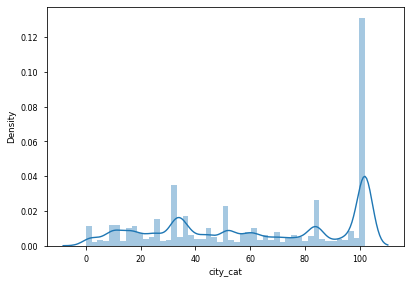

In [116]:
sns.distplot(data_d['city_cat'])

In [117]:
data_d['city_cat'].isna().sum()

0

In [118]:
x = data_d['city_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от города')

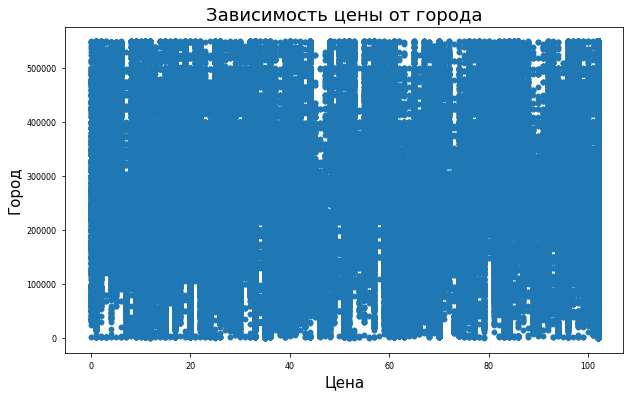

In [119]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Город', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

In [120]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274282 entries, 0 to 377184
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            244823 non-null  object  
 1   private pool      2712 non-null    object  
 2   propertyType      274282 non-null  category
 3   street            274281 non-null  object  
 4   baths             274282 non-null  float64 
 5   homeFacts         274282 non-null  object  
 6   fireplace         274282 non-null  int64   
 7   city              274282 non-null  category
 8   schools           274282 non-null  object  
 9   sqft              274282 non-null  float64 
 10  zipcode           274282 non-null  object  
 11  beds              274282 non-null  int64   
 12  state             274282 non-null  object  
 13  stories           167675 non-null  object  
 14  mls-id            19140 non-null   object  
 15  PrivatePool       22557 non-null   object  
 16  Ml

# Штат

In [121]:
data_d['state'] = data_d['state'].astype('category')
data_d['state_cat'] = data_d['state'].cat.codes
data_d['state_cat'] = data_d['state_cat'].astype('category')

In [122]:
data_d['state_cat'].isna().sum()

0

In [123]:
x = data_d['state_cat']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от штата')

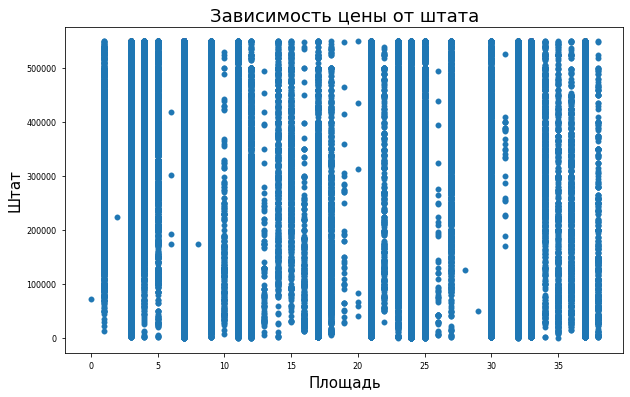

In [124]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Штат', fontsize = 15)
plt.title('Зависимость цены от штата', fontsize = 18)

# Улица

In [125]:
data_d['street'].nunique()

245863

Уникальных значений улиц слишком много. Признак удалила.

 # Stories (надеюсь, это этажи)

In [126]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num(str(x)))


In [127]:
data_d['stories'].isna().sum()

0

<AxesSubplot:xlabel='stories', ylabel='Density'>

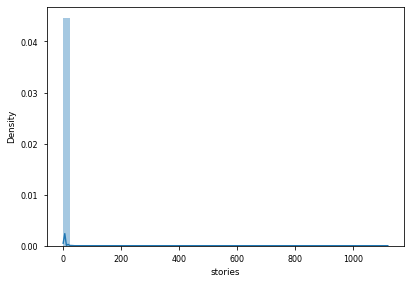

In [128]:
sns.distplot(data_d['stories'])

In [129]:
data_d.loc[data_d['stories']>17]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat
612,for sale,NaN,condo,600 NE 36th St #519,2.0,"[1973, 2005, Forced Air, Central, Attached Gar...",0,Miami,"{'rating': ['2/10', '4/10', '10/10', '2/10', '...",757.0,33137,1,FL,22.0,NaN,NaN,A10584822,245000.0,2019,,,,,,$205/sqft,"['3/10', '3/10', '5/10']","['2.46mi', '0.78mi', '0.96mi']","['9-12', '6-8', 'PK-5']","['Prairie View High School', 'Otho E Stuart Mi...",0,0,0,52,7
1170,for sale,NaN,other,2550 Olinville Ave #2A,1.0,"[1999, , Oil, Central, , 2.24 acres, $263/sqft]",0,Bronx,"{'rating': ['5/10', '7/10', '3/10'], 'data': {...",950.0,10467,2,NY,18.0,NaN,NaN,5104665,250000.0,2017,,Central,Electric,,—,$291 / Sq. Ft.,"['2', '1', '3', '8', '1', '1']","['2.7 mi', '4.1 mi', '1.2 mi', '6.5 mi', '1.4 ...","['Preschool to 4', 'Preschool to 4', '5 to 8',...","['Cotton Elementary School', 'Caldwell Enhance...",0,0,5,5,24
1276,for sale,NaN,other,357 E 57th St #9G,1.0,"[1958, , , , , 8,183 sqft, $998/sqft]",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '1...",500.0,10022,1,NY,21.0,NaN,NaN,NaN,499000.0,1920,1952,Forced air,None,None,"3,388 sqft",$68,"['2/10', '2/10']","['10.2 mi', '9.8 mi']","['PK-9', '5-12']","['Adlai Stevenson School', 'Collinwood High Sc...",0,0,5,58,24
2109,for sale,NaN,condo,600 S Dearborn St #1401,2.0,"[1910, 2015, Heat Pump, Evaporative, Off Stree...",0,Chicago,"{'rating': ['6/10', '7/10'], 'data': {'Distanc...",1200.0,60605,2,IL,22.0,NaN,NaN,10574512,379990.0,,,,,,,$136/sqft,"['8/10', '6/10', '10/10']","['2.6mi', '3.32mi', '0.48mi']","['6-8', '9-12', 'PK-5']","['Hopewell Middle School', 'Stony Point High S...",0,0,0,11,11
3586,for sale,NaN,condo,2201 3rd Ave #1905,1.0,"[1979, 1990, Baseboard, None, Attached Garage,...",1,Seattle,"{'rating': ['7/10', '2/10'], 'data': {'Distanc...",557.0,98121,1,WA,27.0,NaN,yes,1498832,459950.0,1971,1971,Forced air,Central,6 spaces,0.74 acres,None,"['9/10', '6/10', '4/10']","['1 mi', '1.9 mi', '0.6 mi']","['PK-5', '6-8', '9-12']","['Kendale Elementary School', 'Glades Middle S...",0,0,0,86,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363402,Active,NaN,condo,2600 2nd Ave #1409,1.0,"[1993, , Central, Central Air Conditioning, Fo...",0,Seattle,"{'rating': ['2', '6'], 'data': {'Distance': ['...",729.0,98121,1,WA,25.0,NaN,NaN,1494038,535000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,86,37
364480,for sale,NaN,other,200 E 36th St #5H,1.0,"[1955, , , , , 9,250 sqft, $4/sqft]",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '9...",2301.0,10016,1,NY,19.0,NaN,NaN,NaN,525000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,5,58,24
369361,for sale,NaN,other,6636 Yellowstone Blvd #24A,1.0,"[1964, , , , , 0.9 acres, $387/sqft]",0,others,"{'rating': ['5/10', '8/10', '7/10'], 'data': {...",850.0,11375,1,NY,28.0,NaN,yes,NaN,329000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5,102,24
370600,for sale,NaN,other,245 E 54th St #14J,1.0,"[1977, , , , Attached Garage, 0.52 acres, $898...",0,New York,"{'rating': ['9/10', '8/10', '3/10', '8/10', '1...",500.0,10022,1,NY,29.0,NaN,NaN,8679885,449000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5,58,24


In [130]:
data_d = data_d[data_d['stories']<17]

In [131]:
x = data_d['stories']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от этажа')

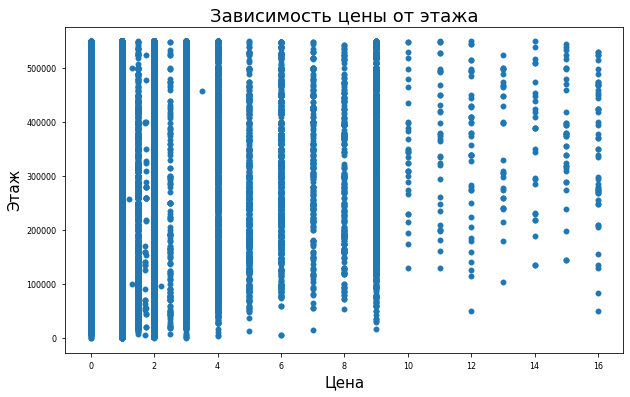

In [132]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Этаж', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

 # Status

In [133]:
data_d['status'].value_counts()

for sale                113218
Active                   76591
For sale                 30301
foreclosure               5150
Pending                   4054
                         ...  
Contingent   No Show         1
Pending Sale                 1
Coming soon: Nov 30.         1
Coming soon: Dec 16.         1
Accepting backups            1
Name: status, Length: 149, dtype: int64

In [134]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

In [135]:
data_d.status = data_d.status.apply(lambda x: str(x))

In [136]:
data_d.status = data_d.status.apply(lambda x: x.lower())

In [137]:
data_d.status = data_d.status.apply(lambda x: 'actv' if (x.find('activ')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cnstr' if (x.find('construction')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntrct' if (x.find('contract')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'pnd' if (x.find('pending')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cntgs' if (x.find('contingen')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'cmg_s' if (x.find('coming soon')>-1) else x)
data_d.status = data_d.status.apply(lambda x: 'frcls' if (x.find('foreclosure')>-1) else x)

In [138]:
data_d['status'].value_counts()

for_sale                 143519
actv                      77419
nan                       29408
frcls                      8468
pnd                        4624
cnstr                      3385
cntrct                     2593
cntgs                       935
p                           781
 / auction                  556
auction                     458
new                         454
price change                408
for rent                    396
foreclosed                  288
back on market              101
cmg_s                        78
pi                           29
due diligence period         26
c continue show              18
c                            18
listing extended              8
apartment for rent            7
condo for rent                7
accepted offer                4
closed                        4
pf                            3
ct                            3
ps                            2
uc continue to show           2
for sale                      1
conting 

Приведение к численному виду.

In [139]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes
data_d['status_cat'] = data_d['status_cat'].astype('category')

In [140]:
data_d['status_cat'].isna().sum()

0

In [141]:
x = data_d['status_cat']
y = data_d['target']


Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

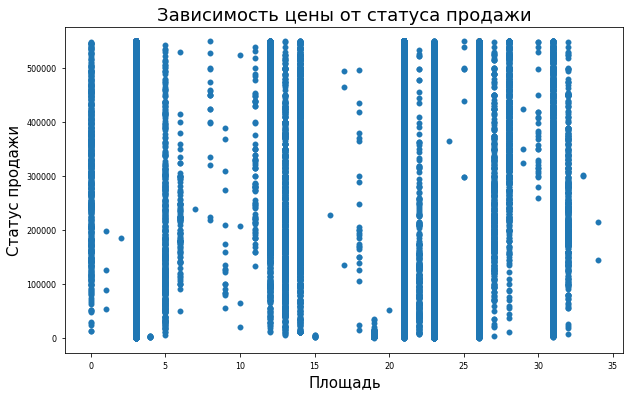

In [142]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Статус продажи', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

# Индекс

In [143]:
data_d['zipcode'].value_counts()

32137         1826
78245         1381
34759         1321
78253         1266
78254         1228
              ... 
27705-3530       1
27603-5569       1
50439            1
47901            1
44704            1
Name: zipcode, Length: 4269, dtype: int64

In [144]:
data_d.zipcode = data_d.zipcode.apply(lambda x: (str(x))[0:2])

In [145]:
data_d.loc[data_d['zipcode']=='--']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat
235207,nan,NaN,twnh,1744 N Dixie Hwy # 1744,3.0,"[2010, None, Forced air, Central, No Data, No ...",0,Fort Lauderdale,"{'rating': ['3/10', '5/10', '7/10'], 'data': {...",2043.0,--,1,FL,1.0,NaN,NaN,"1744, Fort Lauderdale, FL",425000.0,,,,,,0.87 acres,None,"['8/10', '9/10', '9/10']","['5.0mi', '3.18mi', '2.94mi']","['K-5', '6-8', '9-12']","['Northshore Elementary', 'Farragut Middle Sch...",0,0,7,25,7,26


In [146]:
data_d['zipcode'].value_counts()

33    51202
77    25825
32    24558
78    21004
34    13864
      ...  
0         2
35        1
58        1
--        1
00        1
Name: zipcode, Length: 78, dtype: int64

In [147]:
data_d = data_d.drop(data_d[data_d['zipcode']=='--'].index)
data_d = data_d.drop(data_d[data_d['zipcode']=='0'].index)
#data_d = data_d.drop(data_d[data_d['zipcode']=='--'].index)

In [148]:
data_d.zipcode = data_d.zipcode.apply(lambda x: int(x))

In [149]:
data_d['zipcode'].value_counts()

33    51202
77    25825
32    24558
78    21004
34    13864
      ...  
59        8
42        7
35        1
58        1
0         1
Name: zipcode, Length: 76, dtype: int64

In [150]:
data_d['zipcode'].isna().sum()

0

In [151]:
data_d['zipcode'] = data_d['zipcode'].astype('category')

In [152]:
x = data_d['zipcode']
y = data_d['target']

Text(0.5, 1.0, 'Зависимость цены от индекса')

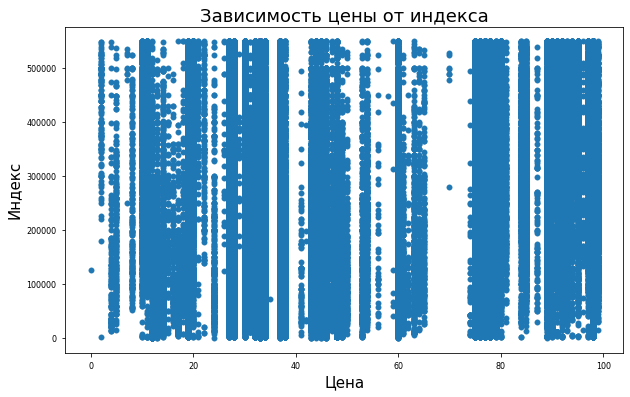

In [153]:
plt.figure(figsize = (10,6))
plt.scatter(x, y)


# добавим подписи
plt.xlabel('Цена', fontsize = 15)
plt.ylabel('Индекс', fontsize = 15)
plt.title('Зависимость цены от индекса', fontsize = 18)

# Обработка признака homeFacts.

Вспомогательная функция для извлечения списка значимых величин из признака. (Извлекает список словарей из исходной структуры, которая тоже является словарем. Затем по ключевым словам словаря формирует список значимых величин. Возвращает нан, если в списке отсутствует ключевое слово основного словаря.)

In [154]:
#def facts_extraction(slovar):
#    if slovar.find('atAGlanceFacts')>-1:
#        slovar1 = eval(slovar)
#       # print(type(slovar1))
#        #print(slovar1)
#        slovar2=slovar1.get('atAGlanceFacts')
#       # print(type(slovar2))
#       # print(slovar2)
#        
#        lst = ['']
#        for i in slovar2:
#            
#            lst.append(i.get('factValue'))
#        lst_res=lst[1:]
#        return lst_res
#            
#    else: return np.NaN

In [155]:
#data_d.homeFacts = data_d.homeFacts.apply(lambda x: facts_extraction(x))

In [156]:
#t = data_d['homeFacts']
#t

In [157]:
#t_lst = t.tolist()

In [158]:
#columns = ['Year built','Remodeled year','Heating','Cooling','Parking','lotsize','price_sqft']

In [159]:
#t1 = pd.DataFrame(t_lst, columns = columns)

In [160]:
#data_d = data_d.join(t1)

In [161]:
#data_d.head(3)

In [162]:
#data_d['price_sqft'].unique()

# Обработка признака школы

In [163]:
#data_d.schools = data_d.schools.apply(lambda x: eval(x[1:-1]))

In [164]:
#t = data_d['schools']
#t

In [165]:
#t_lst = t.tolist()

In [166]:
#t5_lst = []
#for i in t_lst:
#    i1 = dict([('rating', i.get('rating')), ('Distance', (i.get('data')).get('Distance')), ('Grades', (i.get('data')).get('Grades')),('name',i.get('name'))])
#    t5_lst.append(i1)

In [167]:
#df_lst = pd.DataFrame(t5_lst,dtype=str)

In [168]:
#df_lst.head(10)

In [169]:
#data_d = data_d.join(df_lst)

# Разбор нового признака - рейтинг школы

Вспомогательная функция - возвращает численный список: численное значение рейтинга, если рейтинг выражен числом, первое значение дроби или ноль, если встречаются любые другие символы.

In [170]:
data_d['typeRating']=data_d['rating'].apply(lambda x: type(x))

In [171]:
data_d['typeRating'].value_counts()

<class 'str'>      199263
<class 'float'>     74741
Name: typeRating, dtype: int64

In [172]:
data_d.rating=data_d.rating.apply(lambda x: '[]' if type(x)==float else x)

In [173]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,102,21,3,<class 'str'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"['4/10', 'None/10', '4/10']","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,102,37,21,<class 'str'>
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",1655.0,32,1,FL,1.0,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"['3', '3', '1', 'NR']","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",0,0,5,64,7,21,<class 'str'>
5,for_sale,NaN,twnh,1624 S Newkirk St,1.0,"[1920, , Forced Air, Central, , 680 sqft, $233...",0,Philadelphia,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.0,19,2,PA,2.0,NaN,NaN,PAPH847006,209000.0,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"['4', '2', '2']","['0.7 mi', '0.4 mi', '2.2 mi']","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid...",0,0,7,70,30,21,<class 'str'>


In [174]:
data_d.rating=data_d.rating.apply(lambda x: eval(x))

In [175]:
def school_rating1 (lst_r):
    lst_clean = []
    for p in lst_r:
        if p.find('/') == -1:
            if p.isdigit():
                lst_clean.append(int(p))
            else: lst_clean.append(0)
        else:
            num = p[:p.find('/')]
            if num.isdigit():
                lst_clean.append(int(num))
                
            else: lst_clean.append(0)

    return lst_clean

In [176]:
data_d.rating = data_d.rating.apply(lambda x: school_rating1(x))

In [177]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274004 entries, 0 to 377184
Data columns (total 36 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            274004 non-null  category
 1   private pool      2709 non-null    object  
 2   propertyType      274004 non-null  category
 3   street            274003 non-null  object  
 4   baths             274004 non-null  float64 
 5   homeFacts         274004 non-null  object  
 6   fireplace         274004 non-null  int64   
 7   city              274004 non-null  category
 8   schools           274004 non-null  object  
 9   sqft              274004 non-null  float64 
 10  zipcode           274004 non-null  category
 11  beds              274004 non-null  int64   
 12  state             274004 non-null  category
 13  stories           274004 non-null  float64 
 14  mls-id            19134 non-null   object  
 15  PrivatePool       22447 non-null   object  
 16  Ml

# Создание новых признаков: маскимальный рейтинг, средний рейтинг.

In [178]:
data_d['max_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else max(x))

In [179]:
data_d['mean_rating'] = data_d['rating'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

In [180]:
data_d.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,102,21,3,<class 'str'>,7,3.25
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","['1.65mi', '1.32mi', '1.01mi']","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,102,37,21,<class 'str'>,4,2.67
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",1655.0,32,1,FL,1.0,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"[3, 3, 1, 0]","['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi']","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",0,0,5,64,7,21,<class 'str'>,3,1.75


# Разбор нового признака расстояние

Вспомогательная функция возвращает список числовых значений расстояния

In [181]:
data_d.Distance=data_d.Distance.apply(lambda x: '[]' if type(x)==float else x)

In [182]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [183]:
data_d['type_Dist'].value_counts()

<class 'str'>    274004
Name: type_Dist, dtype: int64

In [184]:
data_d.Distance = data_d.Distance.apply(lambda x: eval(x))

In [185]:
data_d['type_Dist'] = data_d['Distance'].apply(lambda x: type(x))

In [186]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,102,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65mi, 1.32mi, 1.01mi]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,102,37,21,<class 'str'>,4,2.67,<class 'list'>
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",1655.0,32,1,FL,1.0,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"[3, 3, 1, 0]","[0.8 mi, 8.3 mi, 4.2 mi, 2.0 mi]","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",0,0,5,64,7,21,<class 'str'>,3,1.75,<class 'list'>
5,for_sale,NaN,twnh,1624 S Newkirk St,1.0,"[1920, , Forced Air, Central, , 680 sqft, $233...",0,Philadelphia,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.0,19,2,PA,2.0,NaN,NaN,PAPH847006,209000.0,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"[4, 2, 2]","[0.7 mi, 0.4 mi, 2.2 mi]","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid...",0,0,7,70,30,21,<class 'str'>,4,2.67,<class 'list'>


In [187]:
data_d['typeRating'].value_counts()

<class 'str'>      199263
<class 'float'>     74741
Name: typeRating, dtype: int64

In [188]:
def distance_select(distance):
    lst_dist = []
    if distance == []: return []
    else:
        for i in distance:
            if i.find(' mi')>-1:
                lst_dist.append(float(i[:-3]))
            elif i.find('mi')>-1:
                lst_dist.append(float(i[:-2]))
            else: lst_dist.append(0)
    return lst_dist

In [189]:
data_d.Distance = data_d.Distance.apply(lambda x: distance_select(x))

In [190]:
data_d.head(4)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,price_sqft,rating,Distance,Grades,name,sqft_big,beds_big,propertyType_cat,city_cat,state_cat,status_cat,typeRating,max_rating,mean_rating,type_Dist
0,actv,NaN,other,240 Heather Ln,3.5,"[2019, , Central A/C, Heat Pump, , , None, $144]",0,others,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2301.0,28,1,NC,1.0,NaN,NaN,611019,418000.0,2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, 0, 4, 7, 0, 0]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', ...","['Southern Pines Elementary School', 'Southern...",1,0,5,102,21,3,<class 'str'>,7,3.25,<class 'list'>
1,for_sale,NaN,other,12911 E Heroy Ave,3.0,"[2019, , , , , 5828 sqft, $159/sqft]",0,others,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1947.0,99,3,WA,2.0,NaN,NaN,201916904,310000.0,2019,,,,,5828 sqft,$159/sqft,"[4, 0, 4]","[1.65, 1.32, 1.01]","['9-12', '3-8', 'PK-8']","['East Valley High School&Extension', 'Eastval...",0,0,5,102,37,21,<class 'str'>,4,2.67,<class 'list'>
4,for_sale,NaN,other,1524 Kiscoe St,1.0,"[, , , , , 10,019 sqft, None]",0,Palm Bay,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",1655.0,32,1,FL,1.0,NaN,NaN,861745,5000.0,2006,2006,"Electric, Heat Pump",Central Air,,"4,996 Sq. Ft.",$120 / Sq. Ft.,"[3, 3, 1, 0]","[0.8, 8.3, 4.2, 2.0]","['Preschool to 4', 'Preschool to 12', '5 to 8'...","['Palmetto Elementary School', 'Haines City Se...",0,0,5,64,7,21,<class 'str'>,3,1.75,<class 'list'>
5,for_sale,NaN,twnh,1624 S Newkirk St,1.0,"[1920, , Forced Air, Central, , 680 sqft, $233...",0,Philadelphia,"{'rating': [], 'data': {'Distance': [], 'Grade...",897.0,19,2,PA,2.0,NaN,NaN,PAPH847006,209000.0,1976,,,,,"8,750 Sq. Ft.",$57 / Sq. Ft.,"[4, 2, 2]","[0.7, 0.4, 2.2]","['Preschool to 5', '6 to 8', '9 to 12']","['Crump Elementary School', 'Hickory Ridge Mid...",0,0,7,70,30,21,<class 'str'>,4,2.67,<class 'list'>


# Добавление новых признаков: минимальное расстояние до школы, среднее расстояние до школы.

In [191]:
data_d['min_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else min(x))
data_d['mean_distance'] = data_d['Distance'].apply(lambda x: 0 if x == [] else round(sum(x)/len(x),2))

# Выделение нового признака - цена за квадратный метр.

In [192]:
data_d['price_sqft'].isna().sum()

106929

In [193]:
def price_clean(price):
    
    if price == None: return np.NaN
    
    elif type(price) == float: return price

    elif price.find('$')>-1: return price_clean(price[1:])
   
    elif price.find('/')>-1: return price_clean(price[0:price.find('/')])
    
    elif price.isnumeric(): return float(price)
    
    else: return np.NaN

In [194]:
data_d.price_sqft = data_d.price_sqft.apply(lambda x: price_clean(x))

In [195]:
data_d['price_sqft'].isna().sum()

137606

# Для модели, построенной для цены за квадратный метр, заполнение убрать.

In [196]:
data_d[['price_sqft']] = data_d[['price_sqft']].fillna(data_d['price_sqft'].median())

In [197]:
data_d['price_sqft'].isna().sum()

0

# Выбор предварительного датафрейма для модели

In [198]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274004 entries, 0 to 377184
Data columns (total 41 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            274004 non-null  category
 1   private pool      2709 non-null    object  
 2   propertyType      274004 non-null  category
 3   street            274003 non-null  object  
 4   baths             274004 non-null  float64 
 5   homeFacts         274004 non-null  object  
 6   fireplace         274004 non-null  int64   
 7   city              274004 non-null  category
 8   schools           274004 non-null  object  
 9   sqft              274004 non-null  float64 
 10  zipcode           274004 non-null  category
 11  beds              274004 non-null  int64   
 12  state             274004 non-null  category
 13  stories           274004 non-null  float64 
 14  mls-id            19134 non-null   object  
 15  PrivatePool       22447 non-null   object  
 16  Ml

In [199]:
columns = data_d.columns

In [200]:
columns = columns.tolist()

In [201]:
columns

['status',
 'private pool',
 'propertyType',
 'street',
 'baths',
 'homeFacts',
 'fireplace',
 'city',
 'schools',
 'sqft',
 'zipcode',
 'beds',
 'state',
 'stories',
 'mls-id',
 'PrivatePool',
 'MlsId',
 'target',
 'Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'price_sqft',
 'rating',
 'Distance',
 'Grades',
 'name',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city_cat',
 'state_cat',
 'status_cat',
 'typeRating',
 'max_rating',
 'mean_rating',
 'type_Dist',
 'min_distance',
 'mean_distance']

In [202]:
lst_remove = ['status','mls-id','private pool',
 'PrivatePool','Year built','state',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'MlsId','propertyType','street','homeFacts','city','schools','rating',
 'Distance',
 'Grades',
 'name','typeRating',
 'type_Dist']

In [203]:
columns = columns
lst_remove = lst_remove
for i in lst_remove:
    columns.remove(i)

In [204]:
#columns.remove('type_Dist')
#columns.remove('zipcode')
#columns.remove('sqft_big')
#columns.remove('beds_big')

In [205]:
columns

['baths',
 'fireplace',
 'sqft',
 'zipcode',
 'beds',
 'stories',
 'target',
 'price_sqft',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city_cat',
 'state_cat',
 'status_cat',
 'max_rating',
 'mean_rating',
 'min_distance',
 'mean_distance']

In [206]:
columns.remove('baths')
columns.remove('fireplace')
columns.remove('beds')

In [207]:
data_d_preliminary=data_d[columns]

In [208]:
data_d_preliminary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274004 entries, 0 to 377184
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   sqft              274004 non-null  float64 
 1   zipcode           274004 non-null  category
 2   stories           274004 non-null  float64 
 3   target            274004 non-null  float64 
 4   price_sqft        274004 non-null  float64 
 5   sqft_big          274004 non-null  int64   
 6   beds_big          274004 non-null  int64   
 7   propertyType_cat  274004 non-null  category
 8   city_cat          274004 non-null  category
 9   state_cat         274004 non-null  category
 10  status_cat        274004 non-null  category
 11  max_rating        274004 non-null  int64   
 12  mean_rating       274004 non-null  float64 
 13  min_distance      274004 non-null  float64 
 14  mean_distance     274004 non-null  float64 
dtypes: category(5), float64(7), int64(3)
memory usage: 

In [209]:
data_d_preliminary.isna().sum()

sqft                0
zipcode             0
stories             0
target              0
price_sqft          0
sqft_big            0
beds_big            0
propertyType_cat    0
city_cat            0
state_cat           0
status_cat          0
max_rating          0
mean_rating         0
min_distance        0
mean_distance       0
dtype: int64

# Визуализация

(10.5, -0.5)

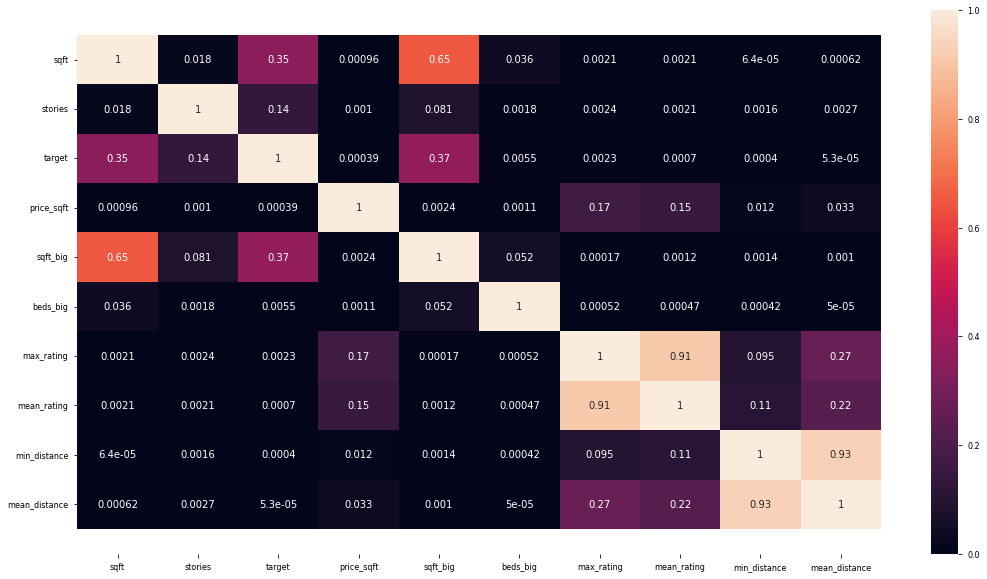

In [210]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [211]:

#data_d_preliminary['state_cat'] = data_d_preliminary[(data_d_preliminary['state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
#sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [212]:
#data_d_preliminary.isna().sum()

In [213]:
#values = {'propertyType_cat':1275}
#data_d_preliminary = data_d_preliminary.fillna(value=values)

In [214]:
#data_d_preliminary = data_d_preliminary.dropna()

In [215]:
#data_d_preliminary.isnull().sum()

# Нормализация

In [216]:
# min_maz_Scaler=preprocessing.MinMaxScaler()

In [217]:
# col=data_d_preliminary.columns
# result=min_maz_Scaler.fit_transform(data_d_preliminary)
# data_d_preliminaty_n=pd.DataFrame(result,columns=col)

In [218]:
# data_d_preliminaty_n

In [219]:
#plt.figure(figsize=(18, 10))
#ax = sns.heatmap(data_d_preliminaty_n.corr().abs(), vmin=0, vmax=1, annot = True)
#i, k = ax.get_ylim()
#ax.set_ylim(i+0.5, k-0.5)

> # Грубая модель

In [220]:
columns = data_d_preliminary.columns
columns = columns.tolist()
columns.remove('target')

In [221]:
columns

['sqft',
 'zipcode',
 'stories',
 'price_sqft',
 'sqft_big',
 'beds_big',
 'propertyType_cat',
 'city_cat',
 'state_cat',
 'status_cat',
 'max_rating',
 'mean_rating',
 'min_distance',
 'mean_distance']

In [222]:
X=data_d_preliminary[columns]

In [223]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274004 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   sqft              274004 non-null  float64 
 1   zipcode           274004 non-null  category
 2   stories           274004 non-null  float64 
 3   price_sqft        274004 non-null  float64 
 4   sqft_big          274004 non-null  int64   
 5   beds_big          274004 non-null  int64   
 6   propertyType_cat  274004 non-null  category
 7   city_cat          274004 non-null  category
 8   state_cat         274004 non-null  category
 9   status_cat        274004 non-null  category
 10  max_rating        274004 non-null  int64   
 11  mean_rating       274004 non-null  float64 
 12  min_distance      274004 non-null  float64 
 13  mean_distance     274004 non-null  float64 
dtypes: category(5), float64(6), int64(3)
memory usage: 22.2 MB


In [224]:
X.isna().sum()

sqft                0
zipcode             0
stories             0
price_sqft          0
sqft_big            0
beds_big            0
propertyType_cat    0
city_cat            0
state_cat           0
status_cat          0
max_rating          0
mean_rating         0
min_distance        0
mean_distance       0
dtype: int64

In [225]:
y = data_d_preliminary[['target']]

In [226]:
y.isna().sum()

target    0
dtype: int64

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

# Тестирование моделей

In [230]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

In [261]:
def grafik(y_test,y_pred):
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, linewidth=1, label="original")
    plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
    plt.title("y-test and y-predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

# Линейная регрессия

In [232]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))


MAE: 99441.24816542065
RMSE: 124135.57644592112
R2: 0.21


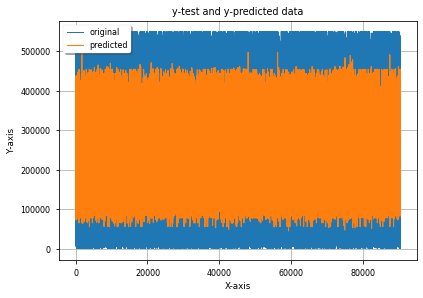

In [262]:
grafik(y_test,y_pred)

# Случайный лес

In [233]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

model =  RandomForestRegressor(n_estimators=10 ,
                               oob_score=True,
                               random_state=RANDOM_SEED)
model.fit(X_train, y_train) # обучение
a = model.predict(X_test) # предсказание
a

score = model.score(X_train, y_train)
print("R-squared:", score) 


R-squared: 0.8819739686259056


In [234]:
y_pred = model.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 69840.5811982156
RMSE: 94493.96740365516
R2: 0.54


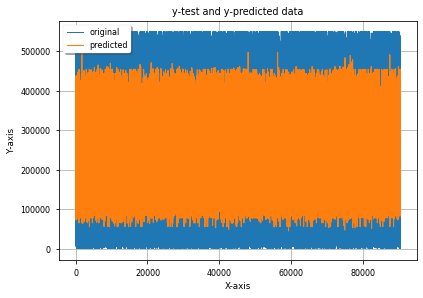

In [263]:
grafik(y_test,y_pred)

# Регрессия с дополнительными деревьями

In [235]:
model = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
predict_extra_tree = model.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)
print(np.array(y_test.index.values))
# оцениваем точность
#print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


[ 78959  10646 244124 ... 133051 130916 283002]


In [236]:
y_pred = model.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 68939.14934308433
RMSE: 94084.10106297025
R2: 0.55


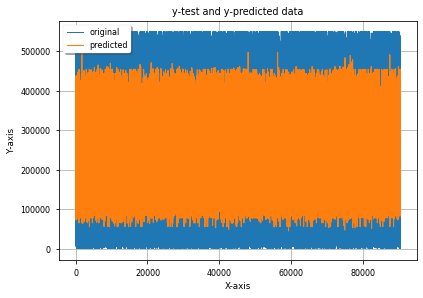

In [264]:
grafik(y_test,y_pred)

# Катбуст

In [237]:
cat_features = ['zipcode','propertyType_cat','state_cat','city_cat','status_cat']

In [238]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         cat_features = cat_features,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 115330.8068071	test: 115312.3592973	best: 115312.3592973 (0)	total: 344ms	remaining: 5m 43s
100:	learn: 84313.7886566	test: 88834.8562072	best: 88704.3095641 (66)	total: 28.5s	remaining: 4m 13s
200:	learn: 79983.1790753	test: 89509.3596722	best: 88704.3095641 (66)	total: 57.4s	remaining: 3m 48s
300:	learn: 76655.7252944	test: 90240.9255846	best: 88704.3095641 (66)	total: 1m 26s	remaining: 3m 20s
400:	learn: 73872.3346430	test: 90804.1151812	best: 88704.3095641 (66)	total: 1m 55s	remaining: 2m 52s
500:	learn: 71353.6387850	test: 91300.4540539	best: 88704.3095641 (66)	total: 2m 24s	remaining: 2m 24s
600:	learn: 69232.6626749	test: 91695.6264423	best: 88704.3095641 (66)	total: 2m 53s	remaining: 1m 55s
700:	learn: 67431.5470423	test: 92092.0488171	best: 88704.3095641 (66)	total: 3m 23s	remaining: 1m 26s
800:	learn: 65856.9220059	test: 92356.9070735	best: 88704.3095641 (66)	total: 3m 53s	remaining: 57.9s
900:	learn: 64325.7495947	test: 92666.4507086	best: 88704.3095641 (66)	total:

In [239]:
y_pred = catboost.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 66426.55342757187
RMSE: 88704.30956414805
R2: 0.6


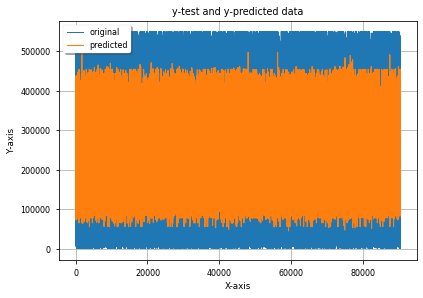

In [265]:
grafik(y_test,y_pred)

Ридж

In [244]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge

In [245]:
ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(X_train, y_train)
print(ridge_regression.predict(X_test))
print(ridge_regression.score(X_test, y_test))

[[141065.54786938]
 [253848.48855958]
 [243700.87452895]
 ...
 [334549.91279698]
 [257177.06174789]
 [225562.96406007]]
0.20975831609711104


In [246]:
y_pred = ridge_regression.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 99441.24597522439
RMSE: 124135.57434212689
R2: 0.21


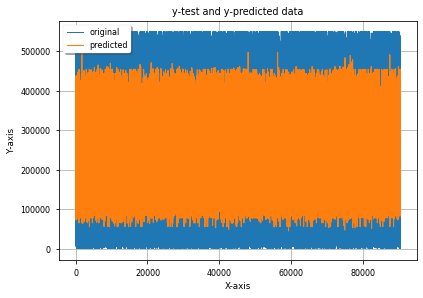

In [266]:
grafik(y_test,y_pred)

Лассо

In [247]:
from sklearn.linear_model import Lasso

In [248]:
lasso_regression = Lasso(alpha=0.1)
lasso_regression.fit(X_train, y_train)
print(lasso_regression.predict(X_test))
print(lasso_regression.score(X_test, y_test))

[141065.43322315 253848.73076113 243701.18887386 ... 334549.24956331
 257177.1473911  225563.1160899 ]
0.20975839135530838


In [249]:
y_pred = lasso_regression.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 99441.24247462841
RMSE: 124135.56843113792
R2: 0.21


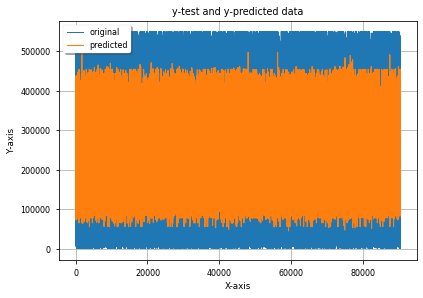

In [267]:
grafik(y_test,y_pred)

Градиентный бустинг

In [252]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train, y_train)

GradientBoostingRegressor()

In [253]:
y_pred = gradient_boosting.predict(X_test)

print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:',metrics.mean_squared_error(y_test, y_pred) ** 0.5)
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

MAE: 77212.98384262016
RMSE: 98876.41936137802
R2: 0.5


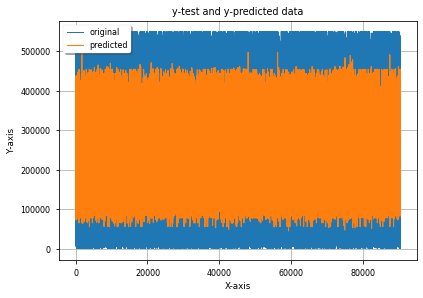

In [268]:
grafik(y_test,y_pred)

# Анализ feature importance

Feature: 0, Score: 75.17928
Feature: 1, Score: 815.45326
Feature: 2, Score: 12318.63173
Feature: 3, Score: 0.11331
Feature: 4, Score: 74472.79033
Feature: 5, Score: -56762.85058
Feature: 6, Score: -10373.07755
Feature: 7, Score: 18.01624
Feature: 8, Score: -1343.80934
Feature: 9, Score: 230.83948
Feature: 10, Score: 491.53323
Feature: 11, Score: -563.58465
Feature: 12, Score: 379.54241
Feature: 13, Score: -280.88111


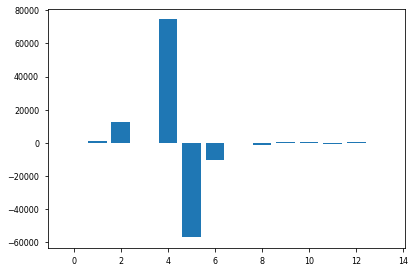

In [241]:
model = LinearRegression()
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [243]:
feature_importance=catboost.feature_importances_
sorted_idx=np.argsort(feature_importance)
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx],align='center')
plt.yticks(range(len(sorted_idx)),np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'